In [ ]:
import pandas as pd
import numpy as np
import re
import torch
import nltk
!pip install jiwer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    get_cosine_schedule_with_warmup
)
from torch.optim import AdamW
from tqdm.notebook import tqdm
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
import jiwer
import matplotlib.pyplot as plt
import logging

In [ ]:
# Download required NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load dataset - Specify the path to your Noakhali dataset
DATASET_PATH = "/content/drive/MyDrive/Dataset/Noakhali/Noakhali Text Translation.csv"

# Load the dataset
try:
    df = pd.read_csv(DATASET_PATH)
    logger.info(f"Loaded Noakhali dataset with shape: {df.shape}")

    # If column names need renaming, do it here
    if 'Noakhali_Language' in df.columns and 'Standard_Bangla_Language' in df.columns:
        df = df.rename(columns={
            'Noakhali_Language': 'Dialect_Text',
            'Standard_Bangla_Language': 'Standard_Text'
        })

    # Print sample data for verification
    print("Sample data:")
    print(df.head())

except Exception as e:
    logger.error(f"Failed to load dataset: {str(e)}")
    raise

# Define column names
dialect_col = 'Dialect_Text'
standard_col = 'Standard_Text'

# Check for missing values
logger.info("Missing values in each column:")
logger.info(df.isnull().sum())

# Handle missing values
if df[dialect_col].isnull().sum() > 0 or df[standard_col].isnull().sum() > 0:
    df = df.dropna(subset=[dialect_col, standard_col])
    logger.info(f"Dataset shape after removing missing values: {df.shape}")

# Data Preprocessing
def preprocess_text(text):
    """Clean the text by removing extra spaces and trimming"""
    if isinstance(text, str):
        # Remove extra spaces
        text = re.sub(' +', ' ', text)
        # Strip leading and trailing spaces
        return text.strip()
    return ""

# Apply preprocessing
df[dialect_col] = df[dialect_col].apply(preprocess_text)
df[standard_col] = df[standard_col].apply(preprocess_text)

# Remove empty rows
df = df[(df[dialect_col] != "") & (df[standard_col] != "")]
logger.info(f"Dataset shape after preprocessing: {df.shape}")

# Remove duplicates
duplicate_count = df.duplicated(subset=[dialect_col, standard_col]).sum()
if duplicate_count > 0:
    logger.info(f"Found {duplicate_count} duplicate entries")
    df = df.drop_duplicates(subset=[dialect_col, standard_col])
    logger.info(f"Dataset shape after removing duplicates: {df.shape}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Sample data:
                              Dialect_Text  \
0                          কেইক্কান আছেন ?   
1                    আইজ্জা আর মন ভালা নাই   
2                           তুমি কিআ করর ?   
3          এতো গরমে আর কিচ্ছু ভালা লাগে না   
4  পোলাডা একটা সাদা রং এর শার্ট পড়ি আইসিলো   

                             Standard_Text Region_Name  
0                               কেমন আছো ?    Noakhali  
1                    আজকে আমার মন ভালো নেই    Noakhali  
2                            তুমি কি করো ?    Noakhali  
3           এই গরমে আমার কিছু ভালো লাগে না    Noakhali  
4  ছেলেটি সাদা রঙয়ের একটি শার্ট পরে এসেছিল    Noakhali  


In [ ]:
# Data augmentation: Add reverse translations
def get_augmented_data(df):
    """Create bidirectional translation examples"""
    # Create reverse translations (standard -> dialect)
    reverse_df = df.copy()
    reverse_df[dialect_col], reverse_df[standard_col] = reverse_df[standard_col], reverse_df[dialect_col]

    # Add task prefixes to distinguish direction
    df['task_prefix'] = 'translate dialect to standard:'
    reverse_df['task_prefix'] = 'translate standard to dialect:'

    return pd.concat([df, reverse_df], ignore_index=True)

# Split data into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Apply augmentation to training data only
augmented_train_df = get_augmented_data(train_df)

logger.info(f"Original train set: {train_df.shape}")
logger.info(f"Augmented train set: {augmented_train_df.shape}")
logger.info(f"Validation set: {val_df.shape}")
logger.info(f"Test set: {test_df.shape}")

In [ ]:

print(f"Original Dataset Shape: {df.shape}")
print(f"Augmented Training Set Shape: {augmented_train_df.shape}")
print(f"Validation Set Shape: {val_df.shape}")
print(f"Test Set Shape: {test_df.shape}")


Original Dataset Shape: (5360, 3)
Augmented Training Set Shape: (7504, 4)
Validation Set Shape: (804, 3)
Test Set Shape: (804, 3)


In [ ]:
# Add task prefixes to validation and test sets
val_df['task_prefix'] = 'translate dialect to standard:'
test_df['task_prefix'] = 'translate dialect to standard:'

# Create Dataset class
class DialectDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128,
                 dialect_col='Dialect_Text', standard_col='Standard_Text',
                 task_prefix_col='task_prefix'):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.dialect_col = dialect_col
        self.standard_col = standard_col
        self.task_prefix_col = task_prefix_col

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        input_text = self.dataframe.iloc[idx][self.dialect_col]
        target_text = self.dataframe.iloc[idx][self.standard_col]

        # Use dynamic task prefix if available
        if self.task_prefix_col in self.dataframe.columns:
            task_prefix = self.dataframe.iloc[idx][self.task_prefix_col]
            input_text = f"{task_prefix} {input_text}"
        else:
            # Fallback to default prefix
            input_text = f"translate dialect to standard: {input_text}"

        # Tokenize inputs and targets
        input_encoding = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        target_encoding = self.tokenizer(
            target_text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # Replace padding token id with -100 for loss calculation
        target_ids = target_encoding["input_ids"].squeeze()
        target_ids[target_ids == self.tokenizer.pad_token_id] = -100

        return {
            "input_ids": input_encoding["input_ids"].squeeze(),
            "attention_mask": input_encoding["attention_mask"].squeeze(),
            "labels": target_ids
        }

In [ ]:
# Load BanglaT5 model and tokenizer
MODEL_NAME = "csebuetnlp/banglat5"
logger.info(f"Loading model: {MODEL_NAME}")

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)

# Create datasets
MAX_LENGTH = 128
train_dataset = DialectDataset(
    augmented_train_df, tokenizer, max_length=MAX_LENGTH,
    dialect_col=dialect_col, standard_col=standard_col
)
val_dataset = DialectDataset(
    val_df, tokenizer, max_length=MAX_LENGTH,
    dialect_col=dialect_col, standard_col=standard_col
)
test_dataset = DialectDataset(
    test_df, tokenizer, max_length=MAX_LENGTH,
    dialect_col=dialect_col, standard_col=standard_col
)

# Create DataLoaders
BATCH_SIZE = 8
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE
)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

# Move model to device
model = model.to(device)

# Set hyperparameters
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 0.01
NUM_EPOCHS = 25  # Reduced from 30 for simplicity, adjust as needed
WARMUP_RATIO = 0.1

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
# Set up optimizer with weight decay
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": WEIGHT_DECAY,
    },
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]
optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE)

# Calculate training steps
NUM_TRAINING_STEPS = NUM_EPOCHS * len(train_loader)
NUM_WARMUP_STEPS = int(NUM_TRAINING_STEPS * WARMUP_RATIO)

# Use cosine schedule with warmup
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=NUM_WARMUP_STEPS,
    num_training_steps=NUM_TRAINING_STEPS
)

# Training function
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc="Training", leave=False)

    for batch in progress_bar:
        # Move batch to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        # Calculate loss
        loss = outputs.loss

        # Backward pass
        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update parameters
        optimizer.step()
        scheduler.step()

        # Update progress bar
        total_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})

    # Return average loss
    return total_loss / len(dataloader)


In [ ]:
# Evaluation function
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_loss += loss.item()

    return total_loss / len(dataloader)

# Translation function
def translate_text(text, model, tokenizer, device, max_length=128,
                  num_beams=5, task_prefix="translate dialect to standard:"):
    model.eval()

    # Prepare input with task prefix
    input_text = f"{task_prefix} {text}"

    # Tokenize input
    input_encoding = tokenizer(
        input_text,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    input_ids = input_encoding["input_ids"].to(device)
    attention_mask = input_encoding["attention_mask"].to(device)

    # Generate translation
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            num_beams=num_beams,
            length_penalty=1.0,
            repetition_penalty=1.2,
            early_stopping=True
        )

    # Decode output
    translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return translated_text

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001, path='best_model.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_score + self.min_delta:
            self.counter += 1
            logger.info(f'Early stopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        logger.info(f'Validation loss decreased ({self.best_score:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)

# Initialize early stopping
early_stopping = EarlyStopping(patience=3, path='drive/MyDrive/best_banglat5_model.pt')

# Training loop with early stopping
train_losses = []
val_losses = []

logger.info(f"Starting training for {NUM_EPOCHS} epochs")
logger.info(f"Model: {MODEL_NAME}")
logger.info(f"Learning rate: {LEARNING_RATE}")
logger.info(f"Batch size: {BATCH_SIZE}")

# Clear GPU memory
torch.cuda.empty_cache()

In [ ]:
# Training loop
for epoch in range(NUM_EPOCHS):
    logger.info(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")

    # Train
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    train_losses.append(train_loss)
    logger.info(f"Train loss: {train_loss:.4f}")

    # Evaluate
    val_loss = evaluate(model, val_loader, device)
    val_losses.append(val_loss)
    logger.info(f"Validation loss: {val_loss:.4f}")

    # Check early stopping
    early_stopping(val_loss, model)

    # Break if early stopping
    if early_stopping.early_stop:
        logger.info("Early stopping triggered")
        break


Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/101 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

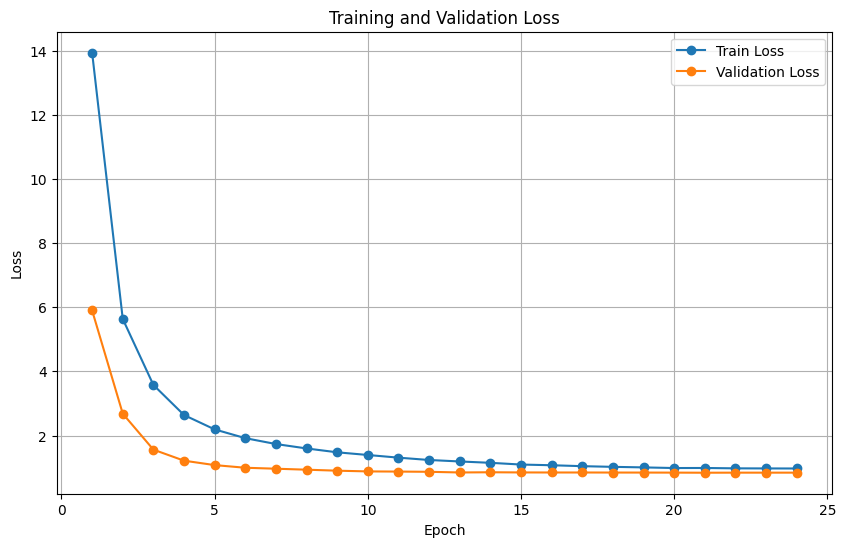

In [ ]:
# Load best model
best_model_path = 'drive/MyDrive/best_banglat5_model.pt'
model.load_state_dict(torch.load(best_model_path))
logger.info(f"Loaded best model from {best_model_path}")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('drive/MyDrive/noakhali_training_loss.png')
plt.show()

In [ ]:
# Calculate metrics functions
def calculate_metrics(original_texts, reference_texts, translated_texts):
    """Calculate BLEU, METEOR, CER, WER scores"""
    # Prepare for BLEU calculation
    references = [[ref.split()] for ref in reference_texts]
    hypotheses = [hyp.split() for hyp in translated_texts]

    # Calculate BLEU scores with different weights
    bleu1_weights = (1, 0, 0, 0)
    bleu2_weights = (0.5, 0.5, 0, 0)
    bleu3_weights = (0.33, 0.33, 0.33, 0)
    bleu4_weights = (0.25, 0.25, 0.25, 0.25)

    bleu1 = corpus_bleu(references, hypotheses, weights=bleu1_weights)
    bleu2 = corpus_bleu(references, hypotheses, weights=bleu2_weights)
    bleu3 = corpus_bleu(references, hypotheses, weights=bleu3_weights)
    bleu4 = corpus_bleu(references, hypotheses, weights=bleu4_weights)

    # Calculate METEOR scores
    meteor_scores = []
    for ref, hyp in zip(references, hypotheses):
        try:
            m_score = meteor_score(ref, hyp)
            meteor_scores.append(m_score)
        except Exception as e:
            logger.warning(f"METEOR calculation error: {str(e)}")
            continue

    meteor_avg = sum(meteor_scores) / len(meteor_scores) if meteor_scores else 0

    # Calculate WER and CER
    wer_scores = []
    cer_scores = []

    for ref, hyp in zip(reference_texts, translated_texts):
        try:
            wer = jiwer.wer(ref, hyp)
            cer = jiwer.cer(ref, hyp)

            wer_scores.append(wer)
            cer_scores.append(cer)
        except Exception as e:
            logger.warning(f"WER/CER calculation error: {str(e)}")
            continue

    avg_wer = sum(wer_scores) / len(wer_scores) if wer_scores else 1.0
    avg_cer = sum(cer_scores) / len(cer_scores) if cer_scores else 1.0

    # Create metrics report
    report = {
        "BLEU-1": bleu1 * 100,
        "BLEU-2": bleu2 * 100,
        "BLEU-3": bleu3 * 100,
        "BLEU-4": bleu4 * 100,
        "METEOR": meteor_avg * 100,
        "WER": avg_wer * 100,
        "CER": avg_cer * 100
    }

    return report

In [ ]:
# Evaluate on test set
logger.info("\nGenerating translations for evaluation metrics...")
original_texts = []
reference_texts = []
translated_texts = []

for idx in tqdm(range(len(test_df))):
    dialect_text = test_df.iloc[idx][dialect_col]
    standard_text = test_df.iloc[idx][standard_col]

    # Generate translation
    translated_text = translate_text(
        dialect_text,
        model,
        tokenizer,
        device
    )

    # Add to lists for evaluation
    original_texts.append(dialect_text)
    reference_texts.append(standard_text)
    translated_texts.append(translated_text)

# Calculate metrics
metrics = calculate_metrics(original_texts, reference_texts, translated_texts)

# Print evaluation metrics
logger.info("\nFinal Evaluation Metrics:")
for metric, value in metrics.items():
    logger.info(f"{metric}: {value:.2f}")

  0%|          | 0/804 [00:00<?, ?it/s]

In [ ]:
# Save results to CSV for analysis
results_df = pd.DataFrame({
    'dialect_text': original_texts,
    'reference_text': reference_texts,
    'translated_text': translated_texts
})

# Save only the results CSV, not all intermediate results
results_path = "drive/MyDrive/noakhali_translation_results.csv"
results_df.to_csv(results_path, index=False)
logger.info(f"Translation results saved to {results_path}")

# Save final model (only once, no checkpoints)
final_model_dir = "drive/MyDrive/noakhali_translator_final"
import os
if not os.path.exists(final_model_dir):
    os.makedirs(final_model_dir)

model.save_pretrained(final_model_dir)
tokenizer.save_pretrained(final_model_dir)
logger.info(f"Final model and tokenizer saved to {final_model_dir}")


In [ ]:
# Create a function to translate new text (simple interface for integration)
def translate_dialect_to_standard(text, model=None, tokenizer=None, device=None):

    if model is None or tokenizer is None or device is None:
        # Load model and tokenizer if not provided
        model_dir = "drive/MyDrive/noakhali_translator_final"
        tokenizer = T5Tokenizer.from_pretrained(model_dir)
        model = T5ForConditionalGeneration.from_pretrained(model_dir)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)

    # Preprocess input text
    text = preprocess_text(text)

    # Translate
    return translate_text(
        text,
        model,
        tokenizer,
        device
    )


In [ ]:
# Test with examples
logger.info("\nTesting with examples:")
test_examples = test_df.head(5)  # Just show a few examples
for idx, row in test_examples.iterrows():
    dialect_text = row[dialect_col]
    standard_text = row[standard_col]

    translated_text = translate_dialect_to_standard(dialect_text, model, tokenizer, device)

    logger.info(f"Dialect: {dialect_text}")
    logger.info(f"Expected: {standard_text}")
    logger.info(f"Translated: {translated_text}")
    logger.info("-" * 50)

In [ ]:

logger.info("\nTesting with examples:")
test_examples = test_df.head(30)  # Just show a few examples
results = []
for idx, row in test_examples.iterrows():
    dialect_text = row[dialect_col]
    standard_text = row[standard_col]
    translated_text = translate_dialect_to_standard(dialect_text, model, tokenizer, device)
    results.append({
        "Dialect": dialect_text,
        "Expected": standard_text,
        "Translated": translated_text
    })
    logger.info(f"Dialect: {dialect_text}")
    logger.info(f"Expected: {standard_text}")
    logger.info(f"Translated: {translated_text}")
    logger.info("-" * 50)

# Now you have the results stored in a list of dictionaries
# You can then use the results list for further processing.
import pprint
pprint.pprint(results)


[{'Dialect': 'গতকাইল রাইতে আরে কই দিলো আই বেলে বেইমান',
  'Expected': 'গতকাল রাতে আমাকে বলে দিলো আমি নাকি বেইমান',
  'Translated': 'গতকাল রাতে আমাকে বলে দিলো আমি বেটে বেইমান'},
 {'Dialect': 'চ্যাল গুয়া করেন।',
  'Expected': 'চাল গুড়ো করুন।',
  'Translated': 'চাল গুঁড়ো করুন।'},
 {'Dialect': 'তুই কি আরে বেকুব মনে করো নি',
  'Expected': 'তুমি কি আমাকে বোকা মনে করো ?',
  'Translated': 'তুমি কি আমাকে বোকা ভাবো নি?'},
 {'Dialect': 'এয়ান হেই সোনালী যুগের প্রাচীন গান যে গান হুইনলে বুকআন ভরি যায়',
  'Expected': 'এই সেই সোনালী যুগের সেই প্রাচীন গান যে গান শুনলে বুকটা ভরে যায়',
  'Translated': 'এই গানটি সোনালী যুগের প্রাচীন গান যা শুনলে মন ভরে যায়'},
 {'Dialect': 'আর হরালেয়া কইত্তে একছের ভালা লাগে না',
  'Expected': 'আমাকে পড়ালেখা করতে একদমই ভাল লাগে না',
  'Translated': 'আমার পড়ালেখা করতে একদমই ভালো লাগে না'},
 {'Dialect': 'হোলাগার রাগ মেলা বেশি',
  'Expected': 'ছেলেটির রাগ অনেক বেশী',
  'Translated': 'ছেলেটির রাগ অনেক বেশি'},
 {'Dialect': 'তোয়ার হরিবারে কি আরে মানি লইব',
  'Expected': 

In [ ]:
# prompt: I want to called translation function for translation one sentence

# Example usage of the translation function
sentence_to_translate = "আইজ্জা আর মন ভালা নাই"
translated_sentence = translate_dialect_to_standard(sentence_to_translate, model, tokenizer, device)
print(f"Original sentence: {sentence_to_translate}")
print(f"Translated sentence: {translated_sentence}")


Original sentence: আইজ্জা আর মন ভালা নাই
Translated sentence: আজকে আমার মন ভালো নেই


In [ ]:
# Create a function to zip and download the model for integration
def zip_model_for_download():
    """Zip the model for download and integration with frontend"""
    import shutil
    from google.colab import files

    zip_path = "/content/noakhali_translator_model.zip"
    shutil.make_archive("/content/noakhali_translator_model", 'zip', final_model_dir)
    print(f"Model zipped at {zip_path}")

    # Download from Colab
    files.download(zip_path)

# Zip model for download (uncomment to use)
zip_model_for_download()

Model zipped at /content/noakhali_translator_model.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print("\nTraining and evaluation complete!")
print(f"Final model saved to: {final_model_dir}")
print(f"Results saved to: {results_path}")
print("\nUse translate_dialect_to_standard() function for new translations.")


Training and evaluation complete!
Final model saved to: drive/MyDrive/noakhali_translator_final
Results saved to: drive/MyDrive/noakhali_translation_results.csv

Use translate_dialect_to_standard() function for new translations.


In [ ]:


# Evaluate on test set
logger.info("\nGenerating translations for evaluation metrics...")
original_texts = []
reference_texts = []
translated_texts = []

for idx in tqdm(range(len(test_df))):
    dialect_text = test_df.iloc[idx][dialect_col]
    standard_text = test_df.iloc[idx][standard_col]

    # Generate translation
    translated_text = translate_text(
        dialect_text,
        model,
        tokenizer,
        device
    )

    # Add to lists for evaluation
    original_texts.append(dialect_text)
    reference_texts.append(standard_text)
    translated_texts.append(translated_text)

# Calculate metrics
metrics = calculate_metrics(original_texts, reference_texts, translated_texts)

# Print evaluation metrics
logger.info("\nFinal Evaluation Metrics:")
for metric, value in metrics.items():
    logger.info(f"{metric}: {value:.2f}")
    print(f"{metric}: {value:.2f}") # Print to standard output as well




  0%|          | 0/804 [00:00<?, ?it/s]

BLEU-1: 72.45
BLEU-2: 61.97
BLEU-3: 51.87
BLEU-4: 41.78
METEOR: 67.36
WER: 26.47
CER: 13.55
